#**UNet++ : A Nested U-Net Architecture for Medical Image Segmentation**

Vinayak Gupta, 28th May 2021

In this project, I have implemented the U-Net++ Architecture - a model which takes in a image as input(neuronal structures in electron microscopic stacks) and gives the segmented image of the input image as output.

This architecture is an upgrade to the previous U-Net model


**U-Net++ Research Paper** 

The information which I am sharing is mostly from this paper. So if you want a very good understanding of the model, you can have a look at the paper [link text](https://arxiv.org/pdf/1807.10165.pdf)



**Dataset Download** 

I have added the train images and segmentated images and also the test input images. The test labels are not available since they are kept secret [link text](https://drive.google.com/drive/folders/1OWcrg0fSsm-vtoeJpeXOJ_VRTgf3JWsf?usp=sharing)



**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [ ]:
!pip install elasticdeform

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import os
from torchvision.utils import save_image
import glob
import math 
from sklearn.model_selection import train_test_split
import gc
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import elasticdeform
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
%matplotlib inline

path = "/content/drive/MyDrive/U-Net_DataSet"
batch_size = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#**Biomedical Segmentation**

#**Loading the Data for Data Augmentation**

In the class Dataload I am loading the images from the google drive linked above. The images and the corresponding labels are loaded into the train_dataset for data augmentation. These are not the images which we will use for training. We will apply elastic deformation on these images and those new augmentated images will be used for training

In [ ]:
class Dataload(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.train_volumes = []
        self.train_labels = []
        self.train_volumes = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_DataSet/train-volume", '*.jpg')))
        self.train_labels = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_DataSet/train-labels", '*.jpg')))

    def __len__(self):
      return len(self.train_volumes)

    def __getitem__(self, index):
        img = Image.open(self.train_volumes[index]).convert('L')             # 'L' converts it into grayscale image         
        label = Image.open(self.train_labels[index]).convert('L')
        img = self.transform(img)
        label = self.transform(label)
        return img, label

transforms = transforms.Compose([
                                transforms.ToTensor(),
                               ])



train_dataset = Dataload(path, transforms)

#**Data Augmentation**


We are given only 30 train images. This is a very low dataset to train on. So we apply elastic deformation to the images and increase the datasize. We can increase the dataset size by how much ever we want. I have increased it to 450 by applying random elastic deformations to the 30 original images 14 times(30*14 + 30)

I have used the elastic deform library given here [link text](https://pypi.org/project/elasticdeform/) You can read more about it in the link given.



In [ ]:
for j in range(1,15):
    for i in range(30):
        X = train_dataset[i][0].numpy()              # Converting the tensor to numpy since we need to input a np array
        Y = train_dataset[i][1].numpy()              # Converting the tensor to numpy since we need to input a np array
        [X_deformed, Y_deformed] = elasticdeform.deform_random_grid([X, Y], sigma=10, points=3, axis = (1,2))        # The value of sigma and the dimension of the grid are given the U-Net paper
        save_image(torch.from_numpy(X_deformed.clip(0, 1).astype('float64')), f"/content/drive/MyDrive/U-Net_Train_Deformed/train-volume/train-volume-{i+1+(j*30)}.jpg")     
        save_image(torch.from_numpy(Y_deformed.clip(0, 1).astype('float64')), f"/content/drive/MyDrive/U-Net_Train_Deformed/train-labels/train-labels-{i+1+(j*30)}.jpg")

I am saving the Images in a new folder. Feel free to change the directory as you wish. While saving the image, I am converting the numpy array to tensor array.

#**U-Net++ Architecture**


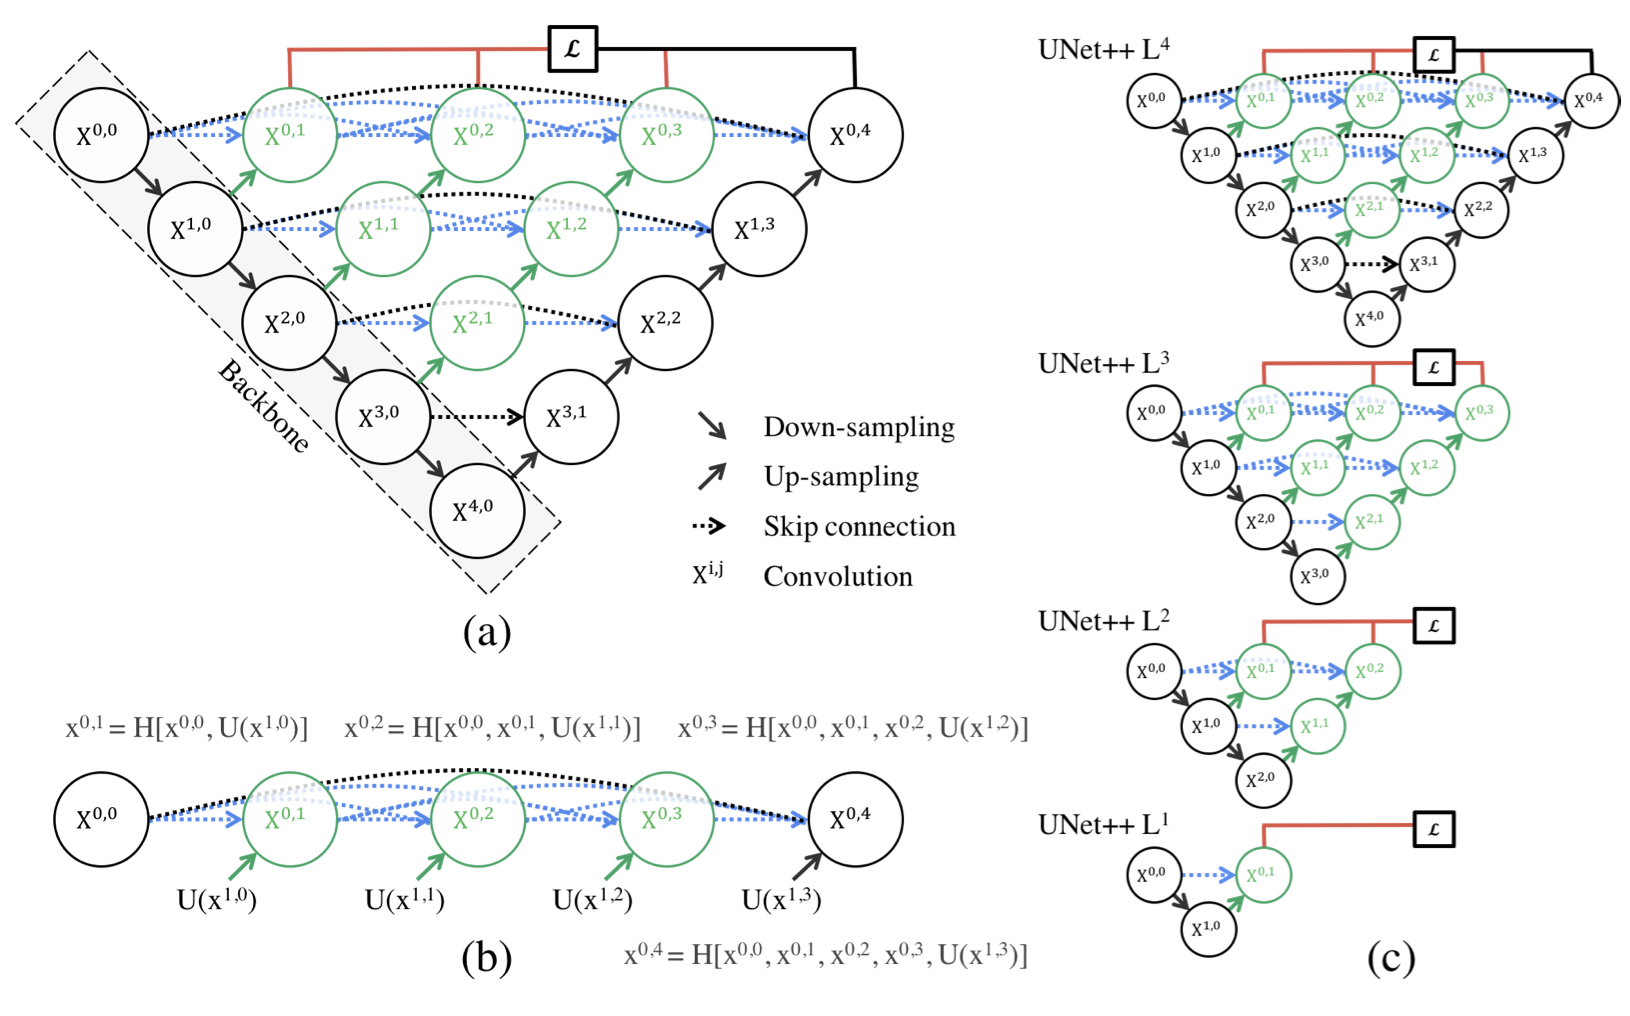

**Encoder** : 
This model is made up of three parts. The first part is the encoder - a contracting path to capture context which basically collects the information on what is present in the image. For example if you show an Image of a cat the encoder part is able to identify that there is a cat in the image but it can't identify where the cat is present in the image since the localization information(positional information) is lost.

**Decoder** : 
This is where the second part of the architecture comes in - the symmetric expanding path that enables precise localization. Here instead of maxpooling layers we use upsampling layers which increase the size of the feature map which increase the resolution of the image. In order to localize, high resolution features from the contracting path are combined by a series of skip connections(Third Part) with the upsampled output. A successive convolution layer can then learn to assemble a more precise output based on this information.

**Skip Pathways** : 
This is the third part of the model which makes it better than the original UNet Architecture. To bridge the semantic gap between the encoder and decoder features we introduce dense convolution blocks between encoder and decoder. Each dense convolution block consists of 3 convolution layers. We introduce skip connection between the encoder, dense convolution blocks and the decoder for smooth gradient flow.

**Normalisation** : I have implemented Group Normalisation. You can learn more about that in [link text](https://arxiv.org/pdf/1809.03783.pdf). You can checkout the pytorch implementation here [link text](https://pytorch.org/docs/stable/generated/torch.nn.GroupNorm.html)

**Initialisation of weights of NN** : As given in the paper, I have initialised weights using a Gaussian distribution with a standard deviation of sqrt(2/N), where N denotes the number of incoming nodes of one neuron. 
E.g. for a 3x3 convolution and 64 feature channels in the previous layer N =9·64=576.

**Dropout** : I am applying dropout so that I can decrease the complexity of the model since it is too high without dropout

**Note** : I have used padding = 'same' in my case, since both the input and output images have same dimension. We need to apply padding so that we do not lose the pixels. Since we have applied padding, we don't need to crop the image while concatenating


In [ ]:
class DenseBlock(nn.Module):

    def __init__(self, inplanes, planes):
        super().__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding=1)
        nn.init.normal_(self.conv1.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.conv3 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.relu = nn.ReLU()
        self.gn = nn.GroupNorm(16, planes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):

        out = self.conv1(x)
        out = self.gn(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.gn(out)
        out = self.relu(out)
        out = self.dropout(out)
        return out

class BasicDownBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv1.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu = nn.ReLU()
        self.gn = nn.GroupNorm(16, planes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        out = self.conv1(x)
        out - self.gn(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.gn(out)
        out = self.relu(out)
        out1 = out
        out = self.maxpool(out)
        out = self.dropout(out)

        return out1, out

class BasicUpBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv1.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=np.sqrt(2/(3*3*planes)))
        self.upconv = nn.ConvTranspose2d(in_channels = planes, out_channels = (planes//2), kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv.weight, mean=0.0, std=np.sqrt(2/(3*3*(planes//2))))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.upconv(out)
        out = self.dropout(out)

        return out

class UNetPP(nn.Module):
    def __init__(self, denseblock, basicdownblock, basicupblock):
        super(UNetPP, self).__init__()
        self.downlayer1 = basicdownblock(inplanes = 1, planes = 64)
        self.downlayer2 = basicdownblock(inplanes = 64, planes = 128)
        self.downlayer3 = basicdownblock(inplanes = 128, planes = 256)
        self.downlayer4 = basicdownblock(inplanes = 256, planes = 512)

        self.dense01 = denseblock(inplanes = 64*3, planes = 64)
        self.dense02 = denseblock(inplanes = 64*4, planes = 64)
        self.dense03 = denseblock(inplanes = 64*5, planes = 64)
        self.dense11 = denseblock(inplanes = 128*3, planes = 128)
        self.dense12 = denseblock(inplanes = 128*4, planes = 128)
        self.dense21 = denseblock(inplanes = 256*3, planes = 256)

        self.uplayer1 = basicupblock(inplanes = 512, planes = 1024)
        self.uplayer2 = basicupblock(inplanes = 1024, planes = 512)
        self.uplayer3 = basicupblock(inplanes = 256*3, planes = 256)
        self.uplayer4 = basicupblock(inplanes = 128*4, planes = 128)

        self.upconv1 = nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv1.weight, mean=0.0, std=np.sqrt(2/(3*3*128)))
        self.upconv2 = nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv2.weight, mean=0.0, std=np.sqrt(2/(3*3*256)))
        self.upconv3 = nn.ConvTranspose2d(in_channels = 512, out_channels = 512, kernel_size = 2, stride = 2)
        nn.init.normal_(self.upconv3.weight, mean=0.0, std=np.sqrt(2/(3*3*512)))

        #self.convds = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1, stride = 1)

        self.conv1 = nn.Conv2d(in_channels = 64*5, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv1.weight, mean=0.0, std=np.sqrt(2/(3*3*64)))
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=np.sqrt(2/(3*3*64)))
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1, stride = 1)
        nn.init.normal_(self.conv3.weight, mean=0.0, std=np.sqrt(2/(1*1*1)))
        self.relu = nn.ReLU()
        self.gn = nn.GroupNorm(16, 64)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):

        out00, x = self.downlayer1(x)
        out10, x = self.downlayer2(x)
        out10_u = self.upconv1(out10)
        out01 = torch.cat((out00, out10_u), 1)
        out01 = self.dense01(out01)
        #seg1 = self.sigmoid(self.convds(out01))
        out20, x = self.downlayer3(x)
        out20_u = self.upconv2(out20)
        out11 = torch.cat((out10, out20_u), 1)
        out11 = self.dense11(out11)
        out30, x = self.downlayer4(x)
        out30_u = self.upconv3(out30)
        out21 = torch.cat((out20, out30_u), 1)
        out21 = self.dense21(out21)
        out11_u = self.upconv1(out11)
        out02 = torch.cat((out00, out01, out11_u), 1)
        out02 = self.dense02(out02)
        #seg2 = self.sigmoid(self.convds(out02))
        out21_u = self.upconv2(out20)
        out12 = torch.cat((out10, out11, out21_u), 1)
        out12 = self.dense12(out12)
        out12_u = self.upconv1(out12)
        out03 = torch.cat((out00, out01, out02, out12_u), 1)
        out03 = self.dense03(out03)
        #seg3 = self.sigmoid(self.convds(out03))

        x = self.uplayer1(x)
        x = torch.cat((out30, x), 1)
        x = self.uplayer2(x)
        x = torch.cat((out20, out21, x), 1)
        x = self.uplayer3(x)
        x = torch.cat((out10, out11, out12, x), 1)
        x = self.uplayer4(x)
        x = torch.cat((out00, out01, out02, out03, x), 1)
        x = self.conv1(x)
        x = self.gn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.gn(x)
        x = self.relu(x)
        x = self.conv3(x)
        #seg4 = x
        seg4 = self.sigmoid(x)
        #seg = (seg1 + seg2 + seg3 + seg4)/4
        
        return seg4

model = UNetPP(DenseBlock, BasicDownBlock, BasicUpBlock)

The convds, seg1, seg2, seg3 are basically useful for Deep Supervision. So if you are using it, then uncomment those lines 

In [ ]:
def make_tensor(tensor):
  if torch.cuda.is_available():
    return torch.cuda.FloatTensor(tensor)
  else:
    return torch.FloatTensor(tensor)

def get_model_summary(model, input_tensor_shape):
    summary(model.to(device), input_tensor_shape)
get_model_summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
         GroupNorm-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
         GroupNorm-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
         MaxPool2d-7         [-1, 64, 256, 256]               0
           Dropout-8         [-1, 64, 256, 256]               0
    BasicDownBlock-9  [[-1, 64, 512, 512], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
        GroupNorm-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
        GroupNorm-14    

#**Loading the Data**

Now I am loading the entire dataset into a dataloader for training. I am diving the dataset into train and val set with ratio 80:20. So 360 images in the training data and 90 images in the validation data.

In [ ]:
class Dataload(Dataset):
    def __init__(self, path, transform):
        self.path = path
        self.transform = transform
        self.train_volumes = []
        self.train_labels = []
        self.train_volumes = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_Train_Deformed/train-volume", '*.jpg')))
        self.train_labels = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_Train_Deformed/train-labels", '*.jpg')))

    def __len__(self):
      return len(self.train_volumes)

    def __getitem__(self, index):
        img = Image.open(self.train_volumes[index]).convert('L')
        label = Image.open(self.train_labels[index]).convert('L')
        img = self.transform(img)
        label = self.transform(label)
        return img, label

transform = transforms.Compose([
                                transforms.ToTensor()
                               ])


train_dataset = Dataload(path, transform)
train_set, val_set = train_test_split(train_dataset, test_size=0.2, random_state=42)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers = 2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers = 2)

I am loading the test data set for testing. I don't have the corresponding segmentation map of test images but we can still compare the results with the test input image 




In [ ]:
class Dataload_Test(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.test_volumes = []
        self.test_volumes = sorted(glob.glob(os.path.join("/content/drive/MyDrive/U-Net_DataSet/test-volume", '*.jpg')))

    def __len__(self):
      return len(self.test_volumes)

    def __getitem__(self, index):
        img = Image.open(self.test_volumes[index]).convert('L')
        img = self.transform(img)
        return img

transforms = transforms.Compose([
                                transforms.ToTensor(),
                               ])

test_dataset = Dataload_Test(transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)

#**Training**

In [ ]:
epoch_train_losses = []              # Defining an empty list to store the epoch losses
epoch_val_losses = []             
accu_train_epoch = []                # Defining an empty list to store the accuracy per epoch
accu_val_epoch = []

I am using a combination of Binary Cross entropy loss and Dice Loss as given in the paper since for every image the output should be either 1 or 0. 0 refers to black which corresponds the segmentation/borders of the cell and 1 refers to white which corresponds to the cell.

The reason why we use Dice Loss is that Dice loss considers the loss information both locally and globally, which is critical for high accuracy. Whereas Binary cross entropy the loss information only discretely(i.e per pixel). Also there is a problem of class imbalance. If you see the photo of segmentation, we have more white spaces than black spaces. So to overcome this issue we use Dice Loss. To get a better understanding of Dice Loss and it's advantage, read this article [link text](https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b)

The reason why we use IoU score instead of normal Pixel Accuracy is because of the class imbalance. For example, if the model full white, still then the pixel accuracy would be around 80% which looks good but it is definitely bad. So we use better metrics like IoU and Dice Coefficient to properly evaluate our metric. To know more about IoU and Dice Coefficient and it's advantage over pixel accuracy, read this article [link text](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)

In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy(input, target)
        smooth = 1e-5
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice             # We are giving more weightage to Dice Loss

batch_size = 1
epochs = 10
lr = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss = BCEDiceLoss()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = output.data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def train(model, dataset, optimizer, criterion, device):

    train_loss_batch = []
    accu_train_batch = []
    model.train()
    for idx,(images, labels) in enumerate(dataset):
      images = images.to(device)
      labels = labels.to(device)

      #Forward Pass
      output = model(make_tensor(images))
    #   print(output)
    #   print(labels)
      output = torch.clip(output, 0.0025, 0.9975)            # I am clipping the output because if it becomes 0 or 1 then there is a chance that loss function can explode
      labels = torch.round(labels)
      train_loss = criterion(output, labels)
      train_loss_batch.append(train_loss)
      output = torch.round(output)
      acc = iou_score(output, labels)
      accu_train_batch.append(acc)
      print(f"Batch: {idx + 1}   Train Loss: {train_loss:.5f}   Accuracy: {acc:.5f}")
      # Backward
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
    epoch_train_losses.append(sum(train_loss_batch)/360)
    accu_train_epoch.append(sum(accu_train_batch)/360)
    print(f"Train Epoch Loss: {(sum(train_loss_batch)/360):.5f}   Train Epoch Accuracy: {(sum(accu_train_batch)/360):.5f}")

def eval(model, dataset, criterion, device):

    val_loss_batch = []
    accu_val_batch = []
    model.eval()
    for idx,(images, labels) in enumerate(dataset):
      with torch.no_grad():
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        output = model(make_tensor(images))
        torch.clip(output, 0.0025, 0.9975)
        # Loss
        val_loss = criterion(output, labels)
        val_loss_batch.append(val_loss)
        output = torch.round(output)
        acc = iou_score(output, labels)
        accu_val_batch.append(acc)
    epoch_val_losses.append((sum(val_loss_batch))/90)
    accu_val_epoch.append((sum(accu_val_batch))/90)
    print(f"Val Epoch Loss: {((sum(val_loss_batch))/90):.5f}   Val Epoch Accuracy: {((sum(accu_val_batch))/90):.5f}")



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Here I am loading the .pt file which I have previously saved while training. This helps me to continue from where I had left.

In [ ]:
best_valid_loss = float('inf')
if os.path.isfile("/content/drive/MyDrive/U-Net++.pt"):
    checkpoint = torch.load('/content/drive/MyDrive/U-Net++.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_best = checkpoint['epoch']
    best_valid_loss = checkpoint['loss']

print(best_valid_loss)

I am saving the model.pt file only if the val_loss is less than previous best val loss so that this way we can save only the best model

In [ ]:
for epoch in range(epochs):

    start_time = time.monotonic()

    print(f"Epoch: {epoch + 1}")
    train(model, train_dataloader, optimizer, loss, device)
    eval(model, val_dataloader, loss, device)
    if best_valid_loss > epoch_val_losses[-1]:
      best_valid_loss = epoch_val_losses[-1]
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_val_losses[-1],
            }, '/content/drive/MyDrive/U-Net++.pt')
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))

print("OVERALL TRAINING COMPLETE")

As you can see that the training and Validation have been decreasing consistantly. 

We see that we are getting a IOU Score of around 97.8% which is great

In [ ]:
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(accu_train_epoch, label='Training Accuracy')
plt.plot(accu_val_epoch, label='Validation Accuracy')
plt.legend()
plt.show()

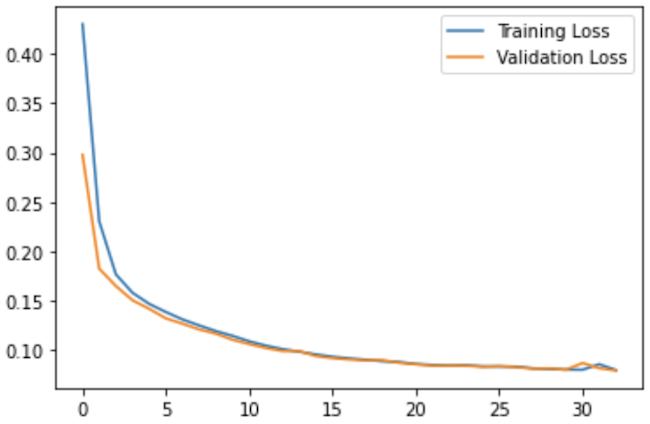

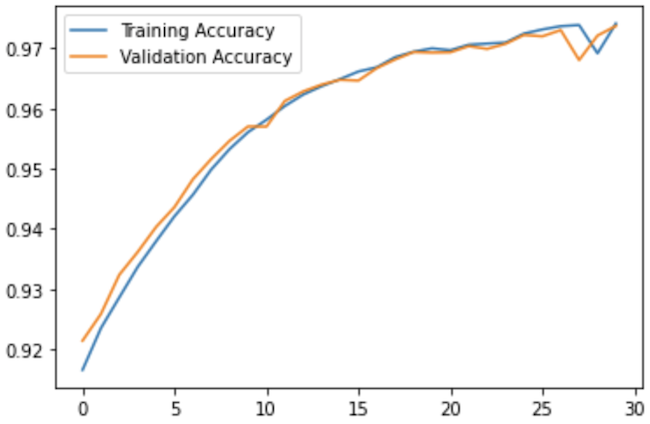

#**Testing**

I am concatenating the test image and the output segmentation map so that we can compare both of them side-by-side. You can remove that line if you wish to only have the segmentation map. The concatenated image as been shown below

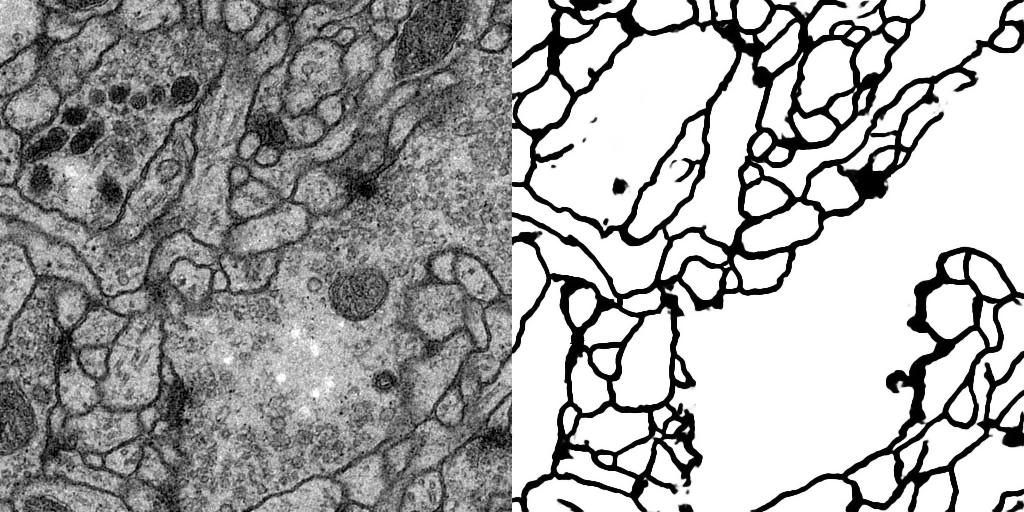

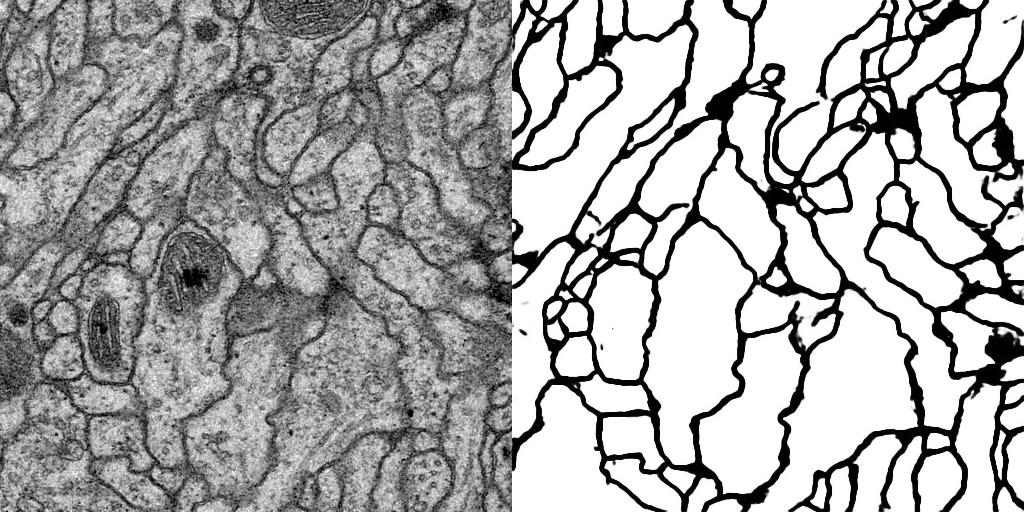

In [ ]:
def test(model, dataset, device):

    model.eval()
    for idx,(images) in enumerate(dataset):
      with torch.no_grad():
        images = images.to(device)
        #Forward Pass
        output = model(make_tensor(images))
        torch.clip(output, 0.0025, 0.9975)
        z = torch.cat((images,output), 3)
        # I am saving the images in my folder. You can save it wherever you wish
        save_image(z.clip(0, 1), f"/content/drive/MyDrive/U-Net++/test_labels/test_labels-{idx+1}.jpg")

test(model, test_dataloader, device)

#**End Note**



Here you go! We have successfully segmented images of electron microscopic stalks with IOU score of around 98%. I have actually left out some of the parts of implementation from the paper like the deep supervision which they had mentioned in the paper. You can experiment and try that for yourselves

Here's a list of things which you can try it out and experiment

1. You can implement the deep supervision technique and check if it increases or decreases the accuracy.

**Advantages of Deep Supervision:**

i) Helps in Faster Convergence since we are learning from 4 segmentation, and hence by applying deep supervision, it will tell the earlier segmentation maps also to learn faster and hence the output segmentation map will learn faster

ii) It will help in variance/overfitting, since we are adding all the 4 losses. If the model is overfitting, then it will choose to learn from the segmentation map before it and hence decrease the model complexity and hence reducing the variance

iii) It also helps in Vanishing/ Exploding Gradient Problem



2. You can maybe use a higher level of deformation by changing sigma and maybe play around a bit with that. Will deforming the image too much affect the accuracy?
